<a href="https://colab.research.google.com/github/ajitonelsonn/ajuda_digital/blob/main/Prosses-Data/Ajuda_Digital_Document_Processing_Jupyter_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ajuda Digital Document Processing - Jupyter Notebook**

## Install Required Packages

In [39]:
# Install required packages
!pip install boto3 openai ipywidgets pillow -q > /dev/null 2>&1

## Import Libraries

In [40]:
import boto3
import json
import uuid
import os
from datetime import datetime
from openai import OpenAI
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import base64
from io import BytesIO
from PIL import Image
import requests

## Configuration Class

In [41]:
# Configuration
class Config:
    # AWS Configuration
    AWS_REGION = 'us-east-1'
    S3_BUCKET = 'pre-proses-ajudagital'

    # SEA-LION API Configuration
    SEA_LION_API_KEY = 'xxxxxxxx'
    SEA_LION_BASE_URL = "https://api.sea-lion.ai/v1"
    SEA_LION_MODEL = "aisingapore/Llama-SEA-LION-v3-70B-IT"

    # Department Models
    DEPARTMENTS = {
        1: "Civil Registry & Identity Model (Registo Civil)",
        2: "Immigration & Travel Model (Imigração e Viagens)",
        3: "Education Model (Educação)",
        4: "Business & Commerce Model (Negócios e Comércio)",
        5: "Legal & Constitutional Model (Jurídico e Constitucional)",
        6: "Elections & Civic Participation (Eleições e Participação Cívica)",
        7: "Health & Social Services (Saúde e Serviços Sociais)",
        8: "Finance & Taxation (Finanças e Tributação)",
        9: "Land & Property (Terras e Propriedade)",
        10: "Employment & Labor (Emprego e Trabalho)"
    }

    SOURCE_OPTIONS = [
        "Facebook",
        "Government Website",
        "Office Information Board",
        "News Website",
        "Other (specify)"
    ]

print("Configuration loaded successfully!")

Configuration loaded successfully!


## Initialize AWS Services

In [42]:
def init_aws_services():
    """Initialize AWS services with credentials"""
    try:
        # Your credentials from the screenshot
        aws_access_key_id = 'xxxxxxxx'
        aws_secret_access_key = 'xxxxxxxx'

        # Initialize AWS clients with explicit credentials
        s3_client = boto3.client(
            's3',
            region_name=Config.AWS_REGION,
            aws_access_key_id=aws_access_key_id,
            aws_secret_access_key=aws_secret_access_key
        )

        textract_client = boto3.client(
            'textract',
            region_name=Config.AWS_REGION,
            aws_access_key_id=aws_access_key_id,
            aws_secret_access_key=aws_secret_access_key
        )

        # Test the connection
        s3_client.list_buckets()

        return s3_client, textract_client
    except Exception as e:
        print(f"Error initializing AWS services: {e}")
        return None, None

# Test AWS connection immediately
s3_client, textract_client = init_aws_services()
if s3_client and textract_client:
    print("AWS services initialized successfully!")

    # Test S3 access
    try:
        buckets = s3_client.list_buckets()
        print(f"Found {len(buckets['Buckets'])} S3 buckets")
    except Exception as e:
        print(f"S3 test failed: {e}")

else:
    print("Failed to initialize AWS services")

AWS services initialized successfully!
Found 7 S3 buckets


## Initialize SEA-LION Client

In [43]:
def init_sea_lion_client():
    """Initialize SEA-LION API client"""
    try:
        client = OpenAI(
            api_key=Config.SEA_LION_API_KEY,
            base_url=Config.SEA_LION_BASE_URL
        )
        return client
    except Exception as e:
        print(f"Error initializing SEA-LION client: {e}")
        return None

# Test SEA-LION connection
sea_lion_client = init_sea_lion_client()
if sea_lion_client:
    print("SEA-LION client initialized successfully!")
else:
    print("Failed to initialize SEA-LION client - check your API key")

SEA-LION client initialized successfully!


## File Upload Widget

In [44]:
def create_upload_widget():
    """Create file upload widget"""
    upload_widget = widgets.FileUpload(
        accept='image/*',
        multiple=False,
        description='Select Image'
    )
    return upload_widget

# Create upload widget
upload_widget = create_upload_widget()
print("File upload widget created!")

File upload widget created!


## Form Widgets

In [45]:
def create_form_widgets():
    """Create all form input widgets"""

    # Tetum language selection
    tetum_checkbox = widgets.Checkbox(
        value=False,
        description='Is this in Tetum language?',
        style={'description_width': 'initial'}
    )

    # Department selection
    department_dropdown = widgets.Dropdown(
        options=[(v, k) for k, v in Config.DEPARTMENTS.items()],
        description='Department:',
        style={'description_width': 'initial'}
    )

    # Source selection
    source_dropdown = widgets.Dropdown(
        options=Config.SOURCE_OPTIONS,
        description='Source:',
        style={'description_width': 'initial'}
    )

    # Custom source input
    custom_source_text = widgets.Text(
        placeholder='Enter custom source...',
        description='Custom Source:',
        style={'description_width': 'initial'}
    )

    # Date picker
    date_picker = widgets.DatePicker(
        description='Date Taken:',
        value=datetime.now().date(),
        style={'description_width': 'initial'}
    )

    # Submit button
    submit_button = widgets.Button(
        description='Process Document',
        button_style='success',
        layout=widgets.Layout(width='200px', height='40px')
    )

    # Progress bar
    progress_bar = widgets.IntProgress(
        value=0,
        min=0,
        max=100,
        description='Processing:',
        bar_style='info',
        style={'description_width': 'initial'}
    )

    return (tetum_checkbox, department_dropdown, source_dropdown,
            custom_source_text, date_picker, submit_button, progress_bar)

# Create form widgets
(tetum_checkbox, department_dropdown, source_dropdown,
 custom_source_text, date_picker, submit_button, progress_bar) = create_form_widgets()

print("Form widgets created!")

Form widgets created!


## Utility Functions

In [46]:
def generate_file_path(department_id, date_taken):
    """Generate unique file path structure"""
    year = date_taken.year
    month = f"{date_taken.month:02d}"
    day = f"{date_taken.day:02d}"

    # Generate unique ID
    unique_id = str(uuid.uuid4()).replace('-', '')[:8]

    base_path = f"doc/{year}/{month}/{day}/{department_id}"
    filename_base = f"doc_{unique_id}_{department_id * 10000 + 1}"

    return base_path, filename_base

def upload_to_s3(s3_client, file_data, bucket, key):
    """Upload file to S3 and return URL"""
    try:
        s3_client.put_object(
            Bucket=bucket,
            Key=key,
            Body=file_data,
            ContentType='application/octet-stream'
        )

        url = f"https://{bucket}.s3.{Config.AWS_REGION}.amazonaws.com/{key}"
        return url
    except Exception as e:
        print(f"Error uploading to S3: {e}")
        return None

print("Utility functions defined!")

Utility functions defined!


## Amazon Textract Function

In [47]:
def extract_text_from_image(textract_client, image_bytes):
    """Extract text from image using Amazon Textract"""
    try:
        response = textract_client.detect_document_text(
            Document={'Bytes': image_bytes}
        )

        # Extract text from response
        text_lines = []
        for item in response['Blocks']:
            if item['BlockType'] == 'LINE':
                text_lines.append(item['Text'])

        extracted_text = '\n'.join(text_lines)
        return extracted_text
    except Exception as e:
        print(f"Error extracting text with Textract: {e}")
        return None

print("Textract function defined!")

Textract function defined!


## SEA-LION Translation Function

In [48]:
def translate_tetum_to_english(sea_lion_client, tetum_text):
    """Translate Tetum text to English using SEA-LION"""
    try:
        completion = sea_lion_client.chat.completions.create(
            model=Config.SEA_LION_MODEL,
            messages=[
                {
                    "role": "user",
                    "content": f"Please translate the following Tetum text to English. Only provide the translation, no additional text:\n\n{tetum_text}"
                }
            ],
            extra_body={
                "chat_template_kwargs": {
                    "thinking_mode": "off"
                }
            },
        )

        translated_text = completion.choices[0].message.content.strip()
        return translated_text
    except Exception as e:
        print(f"Error translating with SEA-LION: {e}")
        return None

print("Translation function defined!")

Translation function defined!


## Main Processing Function

In [49]:
def process_document(upload_widget, tetum_checkbox, department_dropdown,
                    source_dropdown, custom_source_text, date_picker,
                    progress_bar):
    """Main document processing pipeline"""

    # Initialize services
    progress_bar.value = 10
    s3_client, textract_client = init_aws_services()
    sea_lion_client = init_sea_lion_client()

    if not s3_client or not textract_client:
        print("Failed to initialize AWS services")
        return

    if not upload_widget.value:
        print("Please select an image file")
        return

    progress_bar.value = 20

    # Get form values
    file_info = list(upload_widget.value.values())[0]
    image_data = file_info['content']
    original_filename = file_info['metadata']['name']

    is_tetum = tetum_checkbox.value
    department_id = department_dropdown.value
    source = custom_source_text.value if source_dropdown.value == "Other (specify)" else source_dropdown.value
    date_taken = date_picker.value

    # Generate file paths
    base_path, filename_base = generate_file_path(department_id, date_taken)

    progress_bar.value = 30

    # Upload original image
    file_extension = original_filename.split('.')[-1].lower()
    original_key = f"{base_path}/{filename_base}.{file_extension}"
    original_url = upload_to_s3(s3_client, image_data, Config.S3_BUCKET, original_key)

    if not original_url:
        print("Failed to upload original image")
        return

    progress_bar.value = 50

    # Extract text using Textract
    print("Extracting text from image...")
    extracted_text = extract_text_from_image(textract_client, image_data)

    if not extracted_text:
        print("Failed to extract text from image")
        return

    progress_bar.value = 70

    # Create metadata header
    metadata_header = f"""Source: {source}
Department: {Config.DEPARTMENTS[department_id]}
Date Taken: {date_taken}
Original Image: {original_url}
Processed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

---EXTRACTED TEXT---
"""

    # Save original extracted text
    original_text_content = metadata_header + extracted_text
    original_text_key = f"{base_path}/{filename_base}_original.txt"
    original_text_url = upload_to_s3(s3_client, original_text_content.encode('utf-8'),
                                    Config.S3_BUCKET, original_text_key)

    files_created = [
        {"type": "Original Image", "url": original_url},
        {"type": "Original Text", "url": original_text_url}
    ]

    # Translate if Tetum
    if is_tetum and sea_lion_client:
        progress_bar.value = 85
        print("Translating from Tetum to English...")

        translated_text = translate_tetum_to_english(sea_lion_client, extracted_text)

        if translated_text:
            # Create translated text with metadata
            translated_header = f"""Source: {source}
Department: {Config.DEPARTMENTS[department_id]}
Date Taken: {date_taken}
Original Image: {original_url}
Original Text: {original_text_url}
Processed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

---TRANSLATED TEXT (Tetum → English)---
"""
            translated_content = translated_header + translated_text
            translated_key = f"{base_path}/{filename_base}_english.txt"
            translated_url = upload_to_s3(s3_client, translated_content.encode('utf-8'),
                                         Config.S3_BUCKET, translated_key)

            files_created.append({"type": "English Translation", "url": translated_url})
        else:
            print("Translation failed, but original text was saved")

    progress_bar.value = 100

    # Display results
    print(f"\nDocument processed successfully!")
    print(f"Files saved in: https://{Config.S3_BUCKET}.s3.{Config.AWS_REGION}.amazonaws.com/{base_path}/")
    print(f"\nFiles created:")
    for file_info in files_created:
        print(f"   {file_info['type']}: {file_info['url']}")

print("Main processing function defined!")

Main processing function defined!


## Setup Widget Interactions

In [50]:
# Hide/show custom source input based on selection
def on_source_change(change):
    if change['new'] == "Other (specify)":
        custom_source_text.layout.display = 'block'
    else:
        custom_source_text.layout.display = 'none'

source_dropdown.observe(on_source_change, names='value')
custom_source_text.layout.display = 'none'  # Initially hidden

# Submit button click handler
def on_submit_click(button):
    clear_output(wait=True)
    print("Ajuda Digital - Document Processing System")
    print("=" * 50)
    print("Processing document...")
    print()

    process_document(upload_widget, tetum_checkbox, department_dropdown,
                    source_dropdown, custom_source_text, date_picker, progress_bar)

submit_button.on_click(on_submit_click)

print("Widget interactions configured!")

Widget interactions configured!


## Display Interface

In [52]:
print("Ajuda Digital - Document Processing System")
print("=" * 50)
print("This tool processes government document images for the Ajuda Digital chatbot")
print()

# Display interface
display(HTML("<h3>Upload Document Image</h3>"))
display(upload_widget)

display(HTML("<h3>Document Information</h3>"))
display(tetum_checkbox)
display(department_dropdown)
display(source_dropdown)
display(custom_source_text)
display(date_picker)

display(HTML("<h3>Process Document</h3>"))
display(submit_button)
display(progress_bar)

Ajuda Digital - Document Processing System
This tool processes government document images for the Ajuda Digital chatbot



FileUpload(value={'Registuc 2025-08-27 at 09.26.35.jpeg': {'metadata': {'name': 'Registuc 2025-08-27 at 09.26.…

Checkbox(value=True, description='Is this in Tetum language?', style=DescriptionStyle(description_width='initi…

Dropdown(description='Department:', options=(('Civil Registry & Identity Model (Registo Civil)', 1), ('Immigra…

Dropdown(description='Source:', index=2, options=('Facebook', 'Government Website', 'Office Information Board'…

Text(value='', description='Custom Source:', layout=Layout(display='none'), placeholder='Enter custom source..…

DatePicker(value=datetime.date(2025, 8, 26), description='Date Taken:', style=DescriptionStyle(description_wid…

Button(button_style='success', description='Process Document', layout=Layout(height='40px', width='200px'), st…

IntProgress(value=100, bar_style='info', description='Processing:', style=ProgressStyle(description_width='ini…

**Made with ❤️ for Timor-Leste 🇹🇱 — [Ajuda Digital](https://www.ajuda-digital.com) Team**


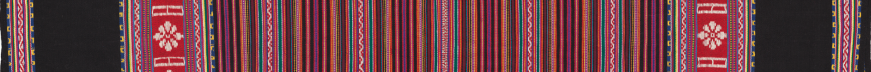